# Introduction

This lab uses a synthetic dataset to compare two different Bayesian regressors: Automatic Relevance Determination and Bayesian Ridge Regression. The first part of the lab compares the models' coefficients with respect to the true coefficients by using an Ordinary Least Squares (OLS) model as a baseline. In the last section, the lab plots predictions and uncertainties for the ARD and the Bayesian Ridge regressions using a polynomial feature expansion to fit a non-linear relationship between **X** and **y**.

# Generate Synthetic Dataset

We generate a synthetic dataset where **X** and **y** are linearly linked. Ten of the features of **X** will be used to generate **y**. The other features are not useful at predicting **y**. In addition, we generate a dataset where **n_samples == n_features**. Such a setting is challenging for an OLS model and leads potentially to arbitrary large weights. Having a prior on the weights and a penalty alleviates the problem. Finally, gaussian noise is added.

In [1]:
from sklearn.datasets import make_regression

X, y, true_weights = make_regression(
    n_samples=100,
    n_features=100,
    n_informative=10,
    noise=8,
    coef=True,
    random_state=42
)

# Fit the Regressors

We fit both Bayesian models and the OLS to later compare the models' coefficients.

In [6]:
import pandas as pd

from sklearn.linear_model import ARDRegression, BayesianRidge, LinearRegression

olr = LinearRegression().fit(X, y)
brr = BayesianRidge(compute_score=True, max_iter=30).fit(X, y)
ard = ARDRegression(compute_score=True, max_iter=30).fit(X, y)
df = pd.DataFrame(
    {
        "Weights of true generative process": true_weights,
        "ARDRegression": ard.coef_,
        "BayesianRidge": brr.coef_,
        "LinearRegression": olr.coef_,
    }
)

# Plot the True and Estimated Coefficients

We compare the coefficients of each model with the weights of the true generative model.

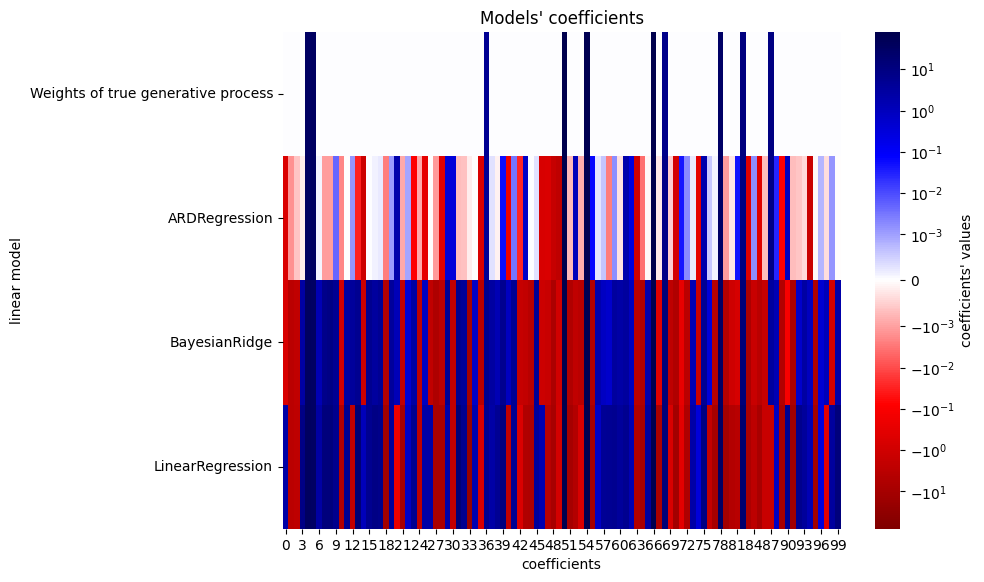

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import SymLogNorm

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    df.T,
    norm=SymLogNorm(linthresh=10e-4, vmin=-80, vmax=80),
    cbar_kws={"label": "coefficients' values"},
    cmap="seismic_r",
)
plt.ylabel("linear model")
plt.xlabel("coefficients")
plt.tight_layout(rect=(0, 0, 1, 0.95))
_ = plt.title("Models' coefficients")

# Plot the Marginal Log-likelihood

We plot the marginal log-likelihood of both models.

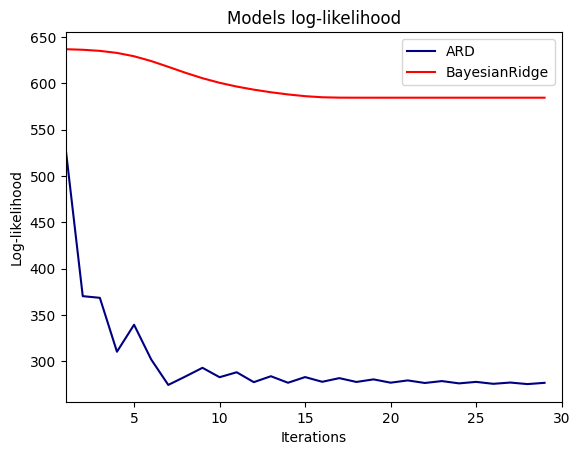

In [8]:
import numpy as np

ard_scores = -np.array(ard.scores_)
brr_scores = -np.array(brr.scores_)
plt.plot(ard_scores, color="navy", label="ARD")
plt.plot(brr_scores, color="red", label="BayesianRidge")
plt.ylabel("Log-likelihood")
plt.xlabel("Iterations")
plt.xlim(1, 30)
plt.legend()
_ = plt.title("Models log-likelihood")

# Generate Synthetic Dataset

We create a target that is a non-linear function of the input feature. Noise following a standard uniform distribution is added.

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

rng = np.random.RandomState(0)
n_samples = 110

# sort the data to make plotting easier later
X = np.sort(-10 * rng.rand(n_samples) + 10)
noise = rng.normal(0, 1, n_samples) * 1.35
y = np.sqrt(X) * np.sin(X) + noise
full_data = pd.DataFrame({"input_feature": X, "target": y})
X = X.reshape((-1, 1))

# extrapolation
X_plot = np.linspace(10, 10.4, 10)
y_plot = np.sqrt(X_plot) * np.sin(X_plot)
X_plot = np.concatenate((X, X_plot.reshape((-1, 1))))
y_plot = np.concatenate((y - noise, y_plot))

# Fit the Regressors

We try a degree 10 polynomial to potentially overfit, though the bayesian linear models regularize the size of the polynomial coefficients. As **fit_intercept=True** by default for ARDRegression and BayesianRidge, then PolynomialFeatures should not introduce an additional bias feature. By setting **return_std=True**, the bayesian regressors return the standard deviation of the posterior distribution for the model parameters.

In [10]:
ard_poly = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    StandardScaler(),
    ARDRegression(),
).fit(X, y)
brr_poly = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    StandardScaler(),
    BayesianRidge(),
).fit(X, y)

y_ard, y_ard_std = ard_poly.predict(X_plot, return_std=True)
y_brr, y_brr_std = brr_poly.predict(X_plot, return_std=True)

# Plotting Polynomial Regressions with Standard Errors of the Scores

The error bars represent one standard deviation of the predicted gaussian distribution of the query points. Notice that the ARD regression captures the ground truth the best when using the default parameters in both models, but further reducing the lambda_init hyperparameter of the Bayesian Ridge can reduce its bias. Finally, due to the intrinsic limitations of a polynomial regression, both models fail when extrapolating.

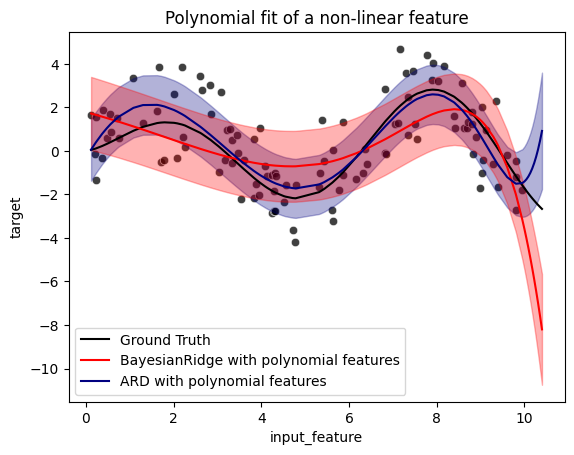

In [11]:
ax = sns.scatterplot(
    data=full_data, x="input_feature", y="target", color="black", alpha=0.75
)
ax.plot(X_plot, y_plot, color="black", label="Ground Truth")
ax.plot(X_plot, y_brr, color="red", label="BayesianRidge with polynomial features")
ax.plot(X_plot, y_ard, color="navy", label="ARD with polynomial features")
ax.fill_between(
    X_plot.ravel(),
    y_ard - y_ard_std,
    y_ard + y_ard_std,
    color="navy",
    alpha=0.3,
)
ax.fill_between(
    X_plot.ravel(),
    y_brr - y_brr_std,
    y_brr + y_brr_std,
    color="red",
    alpha=0.3,
)
ax.legend()
_ = ax.set_title("Polynomial fit of a non-linear feature")

# Summary

This lab compares two different Bayesian regressors using a synthetic dataset. The first part of the lab compares the models' coefficients with respect to the true coefficients by using an Ordinary Least Squares (OLS) model as a baseline. In the last section, the lab plots predictions and uncertainties for the ARD and the Bayesian Ridge regressions using a polynomial feature expansion to fit a non-linear relationship between **X** and **y**.